# Stain Normalization

In [1]:
import numpy as np
import imp
import math
from re import M
from torch import Tensor
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
import random
%matplotlib widget

In [2]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

## Images

In [3]:
img_dir = os.path.join(parent,"data", "processed", "MoNuSeg_TRAIN", "images")
img_paths = sorted(list(map(lambda x: os.path.join(img_dir,x),os.listdir(img_dir))))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
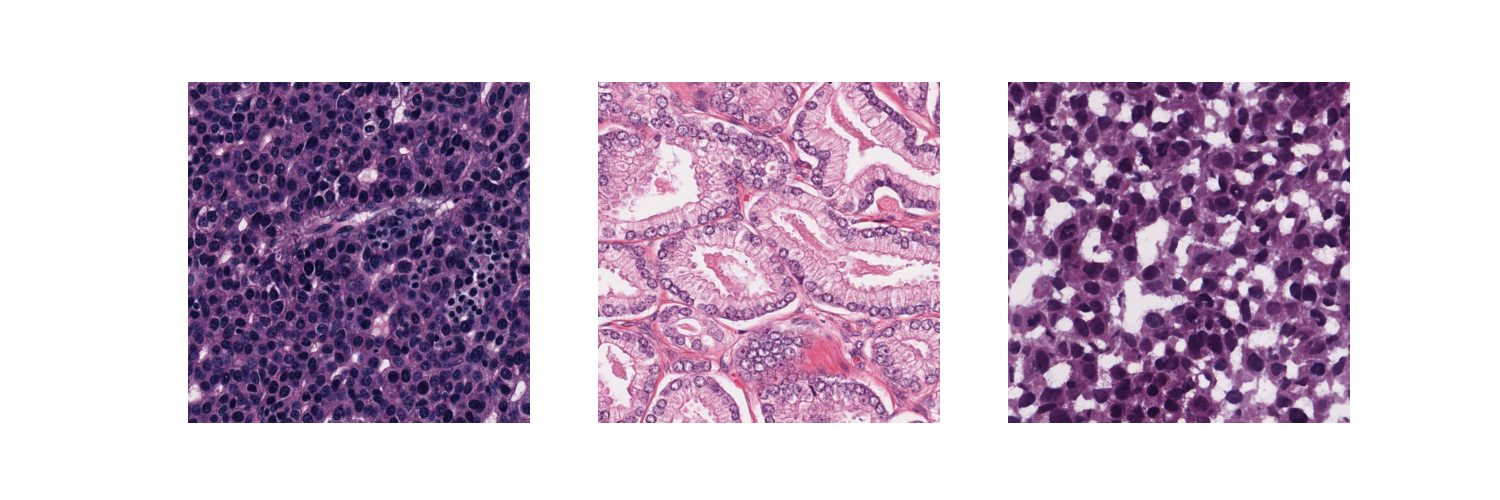

In [4]:
f,ax = plt.subplots(1,3,figsize=(15,5))
for i,img_path in enumerate(img_paths[6:]):
    if i ==3:
        break
    img = Image.open(img_path)
    ax[i].imshow(img)
    ax[i].axis('off')

In [5]:
imgs = [to_tensor(Image.open(img_path)) for img_path in img_paths]

In [6]:
def random_picture(imgs):
    return random.choice(imgs)

def random_pixel(img):
    dim = img.shape
    x,y= random.randint(0,dim[0]-1),random.randint(0,dim[1]-1)
    return img[:,x,y]
    
def random_pixels(max_amt):
    for i in range(max_amt):
        yield random_pixel(random_picture(imgs))
        
def img_pixels(img):
    dim = img.shape
    for x in range(dim[0]):
        for y in range(dim[1]):
            yield img[:,x,y]

In [7]:
def random_sample(tensor,amt):
    return tensor[:,np.random.choice(tensor.shape[1],amt,replace=False)]

## Exploration

### Colour Distribution

In [8]:
pixels = torch.stack(list(random_pixels(10000)),dim=1)
x,y,z = pixels[0],pixels[1],pixels[2]
xod,yod,zod = -torch.log10(x),-torch.log10(y),-torch.log10(z)

In [9]:
def to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(rgb[0],rgb[1],rgb[2])

def rgb_color(x,y,z):
    points = torch.stack([x,y,z],dim=0)
    points = (points*256).int().clip(max=255).T
    return [to_hex(points) for points in points]



(0.0, 1.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
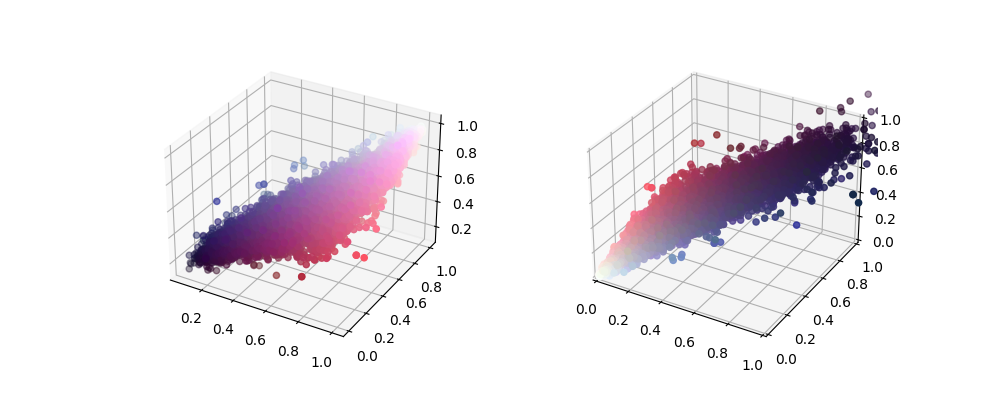

In [10]:
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(1,2,1,projection='3d')
ax.scatter3D(x.numpy(),y.numpy(),z.numpy(),c=rgb_color(x,y,z))

ax = f.add_subplot(1,2,2,projection='3d')
ax.scatter3D(xod.numpy(),yod.numpy(),zod.numpy(),c=rgb_color(x,y,z))
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

## Rotations

In [11]:
from src.utilties.matplot_utilities import *
from src.utilties.vector_utilities import *
from math import *
def plummage(aor,grad):
    f = plt.figure()
    ax = plt.axes(projection='3d')
    inc = torch.pi*2/grad
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    for angle in range(0,grad):
        angle = angle * inc
        vec = Tensor([cos(angle),sin(angle),0]).float()
        vectors = torch.stack([rotate_in_plane(aor,vec,theta*inc) for theta in range(0,grad)]) #todo problem is flipping vec and aor (certain aor is BAD!)
        draw_vectors_3d(ax,vectors,length=1)
    plt.show()
    


In [12]:
#plummage(y_axis*2+z_axis,200)

## Macenko

In [13]:
def normalize_vec(vec: Tensor):
    return vec / vec.norm(p=2, dim=0)


In [14]:
def get_stain_vectors(img: Tensor, alpha=0.01, beta=0.15,clipping=4,debug=True):
    """Gets the stain vectors for an image in RGB
        Implemets the Macenko et al. (2016) method for stain normalization.
    Args:
        img (tensor): The RGB H&E image
    """
    flat_img = img.flatten(1, 2)
    # 1) get optical density

    od = -torch.log10(flat_img)

    # 2) prune small intensity (high noise?). Must have at least component above beta
    indices = ((od > beta).nonzero().permute(1, 0))[1]
    od = od[:, indices]
    od = od.clip(0, clipping)  # in case we get infinite point
    
    
    # 3) Get SVD (actually Eigen decomposition of Covariance)

    covmatrix = torch.cov(od)
    
    e, v = torch.linalg.eigh(covmatrix)
    v1, v2 = not_neg(normalize_vec(v[:,2]).float()), not_neg(normalize_vec(v[:,1]).float()) # because v[:,2] is the largest eigenvalue

    assert abs(v1.norm(p=2).item()-1) < 1e-5
    assert abs(v2.norm(p=2).item() - 1) < 1e-5

    assert abs(torch.dot(v1, v2).item()) < 1e-5
    
    
    # TODO DRAW GRAPH 1
    if debug:
        od_sample = random_sample(od,10000)
        xod,yod,zod = od_sample[0],od_sample[1],od_sample[2]
        x,y,z= torch.pow(10,-xod),torch.pow(10,-yod),torch.pow(10,-zod)
        f = plt.figure(figsize=(5,5))
        ax = f.add_subplot(1,1,1,projection='3d')
        ax.scatter3D(xod.numpy(),yod.numpy(),zod.numpy(),c=rgb_color(x,y,z))
        draw_vectors_3d(ax,torch.stack([v1,v2],dim=0),length=0.4,color='b')
        draw_plane(ax,v1,v2,color='b')
        #draw_annotated_vector_3d(ax,v1,(0,0,0),"Eigenvector 1")
        #draw_annotated_vector_3d(ax,v2,(0,0,0),"Eigenvector 2")
        ax.set_xlim(0)
        ax.set_ylim(0)
        ax.set_zlim(0)
        ax.set_xlabel('OD RED')
        ax.set_ylabel('OD GREEN')
        ax.set_zlabel('OD BLUE')
        plt.show()
    
    
    
    
    # 4&5) Project points on the the plane and normalize
    perp = torch.cross(v1, v2).float()
    perp = not_neg(normalize_vec(perp))

    dist = perp @ od
    proj = od - (perp.unsqueeze(1) @ dist.unsqueeze(0))
    proj = normalize_vec(proj)

    assert abs(proj.norm(p=2, dim=0).mean().item() - 1) < 1e-5
    
    # 6) Get angles

    #angles = torch.acos(torch.matmul(v1.T, proj).clip(-1, 1)) #todo clips wrong part! First rotate
    
    offset_angle = torch.pi/2
    rot_proj = rotate_in_plane(proj,perp,offset_angle) # in order to make all vectors in the same area
    angles = torch.acos(torch.matmul(v1.T, rot_proj).clip(-1, 1))
    
    #print(angles.isnan().sum())
    min_ang, max_ang = np.percentile(angles.numpy(), [alpha, 100-alpha])
    min_ang -= offset_angle
    max_ang -= offset_angle
    #print(min_ang,max_ang)
    #print(v1,perp)
    # 7) Get the stain vectors
    stain_v1 = normalize_vec(rotate_in_plane(v1, perp, min_ang))
    stain_v2 = normalize_vec(rotate_in_plane(v1, perp, max_ang))
    

    
    
    # TODO DRAW GRAPH 2
    if debug:
        od_sample = random_sample(od,100000)
        dist_sample = perp @ od_sample
        proj_sample = od_sample - (perp.unsqueeze(1) @ dist_sample.unsqueeze(0))
        norm_proj_sample = normalize_vec(proj_sample)
        
        inverse_basis = torch.linalg.pinv(torch.stack([v1,v2]).T)
        
        components = inverse_basis@ proj_sample
        norm_components = inverse_basis@ norm_proj_sample
        x,y,z= torch.pow(10,-od_sample[0]),torch.pow(10,-od_sample[1]),torch.pow(10,-od_sample[2]) # rgb of the sampled points
        
        sv1_comp,sv2_comp = inverse_basis@stain_v1,inverse_basis@stain_v2
        
        f = plt.figure(figsize=(5,5))
        ax = f.add_subplot(1,1,1)
        ax.scatter(components[0].numpy(),components[1].numpy(),c=rgb_color(x,y,z))
        ax.scatter(norm_components[0].numpy(),norm_components[1].numpy(),c="g")
        draw_vector_2d(ax,sv1_comp*2,color="blue")
        draw_vector_2d(ax,sv2_comp*2,color="blue")
        plt.show()
    

    
    # TODO DRAW GRAPH 3
    if debug:
        od_sample = random_sample(od,10000)
        xod,yod,zod = od_sample[0],od_sample[1],od_sample[2]
        x,y,z= torch.pow(10,-xod),torch.pow(10,-yod),torch.pow(10,-zod)
        
        dist_sample = perp @ od_sample
        proj_sample = od_sample - (perp.unsqueeze(1) @ dist_sample.unsqueeze(0))
        norm_proj_sample = normalize_vec(proj_sample)
        
        f = plt.figure(figsize=(5,5))
        ax = f.add_subplot(1,1,1,projection='3d')
        ax.scatter3D(xod.numpy(),yod.numpy(),zod.numpy(),c=rgb_color(x,y,z))
        draw_vectors_3d(ax,torch.stack([v1,v2],dim=0),length=0.4,color='b')
        draw_plane(ax,v1,v2,color='b')
        
        ax.scatter3D(norm_proj_sample[0].numpy(),norm_proj_sample[1].numpy(),norm_proj_sample[2].numpy(),c='black')
        draw_vectors_3d(ax,torch.stack([stain_v1,stain_v2],dim=0),length=2,color='b')
        ax.set_xlim(0)
        ax.set_ylim(0)
        ax.set_zlim(0)
        ax.set_xlabel('OD RED')
        ax.set_ylabel('OD GREEN')
        ax.set_zlabel('OD BLUE')
        plt.show()
    
    

    
        
    assert abs(stain_v1.norm(p=2).item()-1) < 1e-5
    assert abs(stain_v2.norm(p=2).item()-1) < 1e-5

    
    # Back to RGB
    stain_v1, stain_v2 = torch.pow(10,-stain_v1 ), torch.pow(10,-stain_v2 )
    stain_v1, stain_v2 = normalize_vec(stain_v1), normalize_vec(stain_v2)
    
    
    
    
    if(stain_v1[0]<stain_v2[0]):
        stain_v1, stain_v2 = stain_v2, stain_v1
    
    return stain_v1, stain_v2




In [15]:
#img = imgs[6]
#get_stain_vectors(img, alpha=0.1,debug=True)

## Challenges
### 1) Dark Stained Images
14.tif was a particularly troublesome image because it looks so different from the rest. It is much darker. Points which are black become infinite points in OD. This corresponds mathematically to a point of infinite staining, so we need to clip to account for this. Since there are many such spots

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
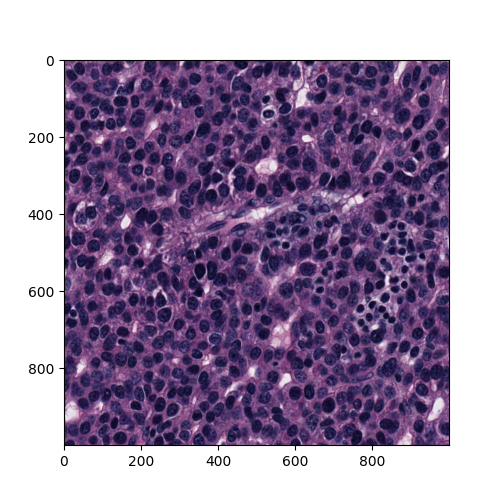

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
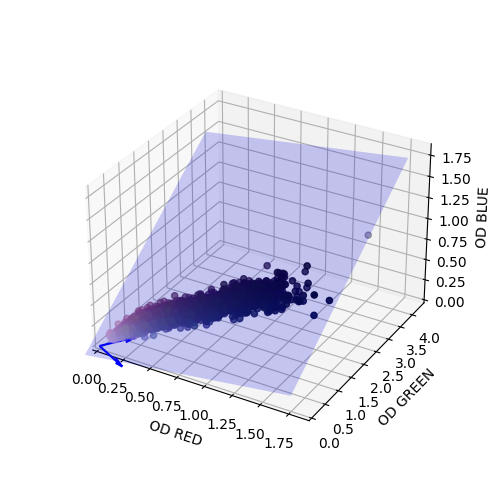

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
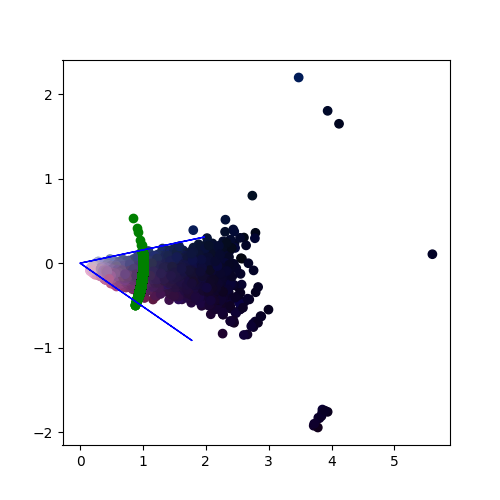

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
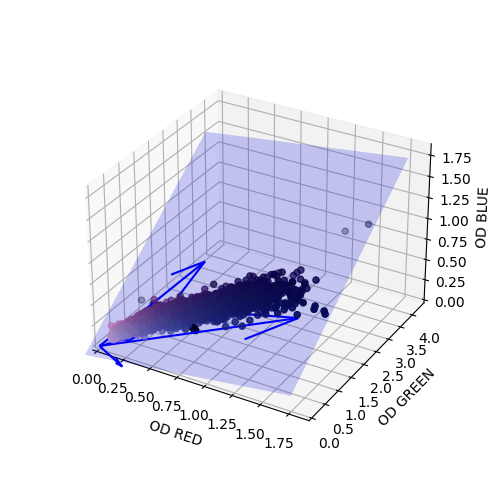

(tensor([0.7653, 0.1769, 0.6189]), tensor([0.2904, 0.4863, 0.8241]))

In [16]:
f = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)
ax.imshow(imgs[6].permute(1,2,0))
plt.show()

get_stain_vectors(imgs[6],debug=True)

## Stain Vectors

In [17]:
from src.transforms.he_normalize import get_stain_vectors

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
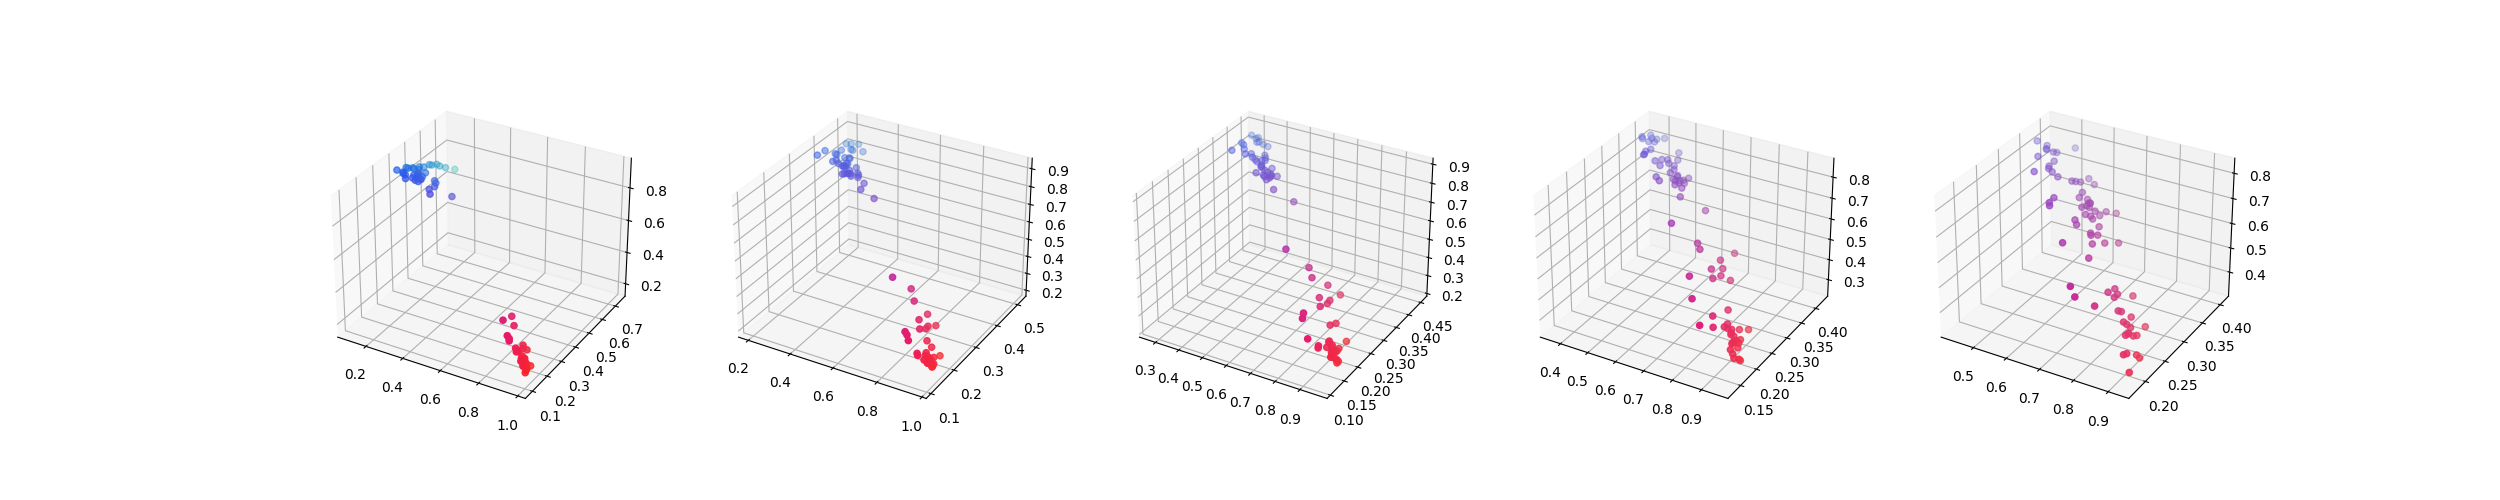

In [26]:
alphas = [0,0.01,0.1,1,10]
f = plt.figure(figsize=(25,5))
for i,alpha in enumerate(alphas):
    ax = plt.subplot(1,len(alphas),i+1,projection='3d')
    vectors = [get_stain_vectors(img, alpha=alpha) for img in imgs]
    vectors = torch.stack(vectors).flatten(0,1).permute(1,0)
    
    x,y,z = vectors[0],vectors[1],vectors[2]
    
    v1s = torch.stack(vectors)[:,0]
    v2s = torch.stack(vectors)[:,1]
    v1m,v2m = v1s.mean(dim=0),v2s.mean(dim=0)
    means = torch.stack([v1m,v2m]).T
    
    ax.scatter3D(x.numpy(),y.numpy(),z.numpy(),c=rgb_color(x,y,z))
    ax.scatter3D(v1m[0].numpy(),v1m[1].numpy(),v1m[2].numpy(),c='r')


# Normalizing Image

In [ ]:
def he_normalize(img):
    v1,v2 = get_stain_vectors(img, alpha=0.01)
    

## Citations

- "A Method for Normalizing Hiostology Sliders for Quantitative Analysis" - Macenko et. al
- [Explorative Explanation](https://towardsdatascience.com/microscopy-stain-variations-and-how-to-estimate-them-baca29f57ee9)